In [1]:
import networkx as nx
import scipy.sparse as sp
import numpy as np
import graph_utils as utils
import torch
import torch
from collections import defaultdict
import numpy as np
import time
import json

In [2]:
seed=114514
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.seed_all()

# **Read data**

In [3]:
loader = np.load('gene_with_label.npz')
train_ones = loader['edges']
labels=loader['labels']
print(len(train_ones))
print(train_ones[:5])

2872
[[  0  60]
 [  0 622]
 [  1 345]
 [  2  39]
 [  2  56]]


In [4]:
adj_sparse = np.zeros((np.max(train_ones)+1,np.max(train_ones)+1))
for e in train_ones:
    adj_sparse[e[0],e[1]]=1
    adj_sparse[e[1],e[0]]=1
    
adj_sparse = sp.coo_matrix(adj_sparse).tocsr()

lcc = utils.largest_connected_components(adj_sparse)
adj_sparse= adj_sparse[lcc,:][:,lcc]
_N = adj_sparse.shape[0]
print('n',_N)
_Edges=[]
for x in np.column_stack(adj_sparse.nonzero()):
    if not x[0]==x[1]:
        _Edges.append((x[0],x[1]))
_num_of_edges=int(len(_Edges)/2)
print('m',_num_of_edges)

dic=defaultdict(set)
for x in _Edges:
    a1=x[0]
    a2=x[1]
    dic[a1].add(a2)
    dic[a2].add(a1)
    

adj_origin=np.zeros((_N,_N)).astype(int)
for (i,j) in _Edges:
    adj_origin[i][j]=1
    adj_origin[j][i]=1
assert(np.sum(adj_origin==adj_origin.T)==_N*_N)
assert(np.sum(adj_origin)==_num_of_edges*2)

Selecting 1 largest connected components
n 814
m 1436


In [5]:
_Edges=np.array(_Edges).astype(int)
np.save('gene_edges.npy',_Edges)

# **1.Get link prediction model and embedding**

In [6]:
embedding_dim=128
node_class=2

graphsagemodel=utils.GraphSAGE(_N=_N,_M=_num_of_edges,adj_origin=adj_origin,
                                         adj_dic=dic,embedding_dim=embedding_dim)


# *1.2 Load pretrained model*

In [7]:
graphsagemodel.load_model(path='graphsage.pth',embedding_path='embeddings_matrix.npy')

In [8]:
embedding_matrix_numpy=graphsagemodel.embedding_matrix_numpy
link_prediction_model=graphsagemodel.graphsage_link_prediction_from_embedding_one_to_other

# **2.GAN generate new embeddings**

In [9]:
batch_size=256
noise_dim=16
g_hidden_dim=[32,64,100]
d_hidden_dim=[100,64,32]
lendataloader=20
Diter=5
Giter=1
epoch_numbers=10000
eval_epoch=200


In [10]:
netG = utils.Generator(noise_dim=noise_dim,embedding_dim=embedding_dim+2, g_hidden_dim=g_hidden_dim,batch_size=batch_size).cuda()

In [11]:
netG.load_state_dict(torch.load('gan_model_pretrained/bestG.pth'))

<All keys matched successfully>

# *2.2.2compute ECDF*

2


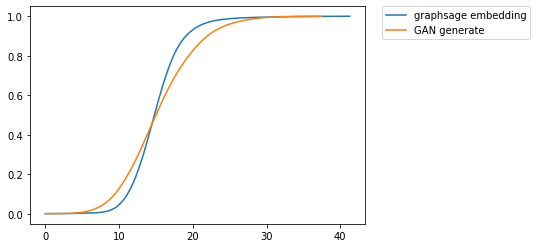

[[0.         0.         2.2181015  0.         0.        ]
 [0.         0.         0.13831477 1.6214032  0.        ]
 [0.         0.         1.2885387  3.5342638  0.        ]]
[[0.00000000e+00 1.00000000e+00 1.03166521e+00 0.00000000e+00
  1.59045100e-01]
 [0.00000000e+00 1.00000000e+00 1.91578984e-01 3.49158692e+00
  4.36463766e-02]
 [2.19802969e-37 1.00000000e+00 4.10909913e-02 1.89892602e+00
  1.40137896e-01]]
0.003531879
0.0001841364425255368
0.0022699298787681567


(0.005433536040648946, 814)

In [12]:
train_embeddings=np.zeros((_N,128+2))
train_embeddings[:,:128]=embedding_matrix_numpy[:,:]
print(np.max(labels))
for i in range(_N):
    train_embeddings[i,labels[i]-1]=1
utils.eval_plot(netG,embedding_matrix=train_embeddings,noise_dim=16,mmd_beta=0.1)

# **3.Sample**

In [13]:
def save_graph(adj_generate,labels,dirpath,embeddings=None):
    edges=[]
    for i in range(_N):
        for j in range(i+1,_N):
            if adj_generate[i][j]==1:
                edges.append((i,j))
    edges=np.array(edges).astype(int)
    np.savez(dirpath, edges=edges, labels=labels,embeddings=embeddings)

In [14]:
def edgeoverlap_generate(generate_graph,adj_origin):
    tp=0
    tn=0
    fp=0
    fn=0
    for i in range(_N):
        for j in range(_N):
            if generate_graph[i,j]==1 and adj_origin[i,j]==1:
                tp=tp+1
            if generate_graph[i,j]==0 and adj_origin[i,j]==1:
                fp=fp+1
            if generate_graph[i,j]==1 and adj_origin[i,j]==0:
                fn=fn+1
            if generate_graph[i,j]==0 and adj_origin[i,j]==0:
                tn=tn+1
        print('\r%d/%d'%(i,_N),end="")
    print('\n')
    print('Edge overlap between generate graph and original graph')
    print(generate_graph.shape)
    total_num=_N*_N
    print('True Positve:%d, %.2f'%(tp,tp/(tp+fp)))
    print('False Positve:%d, %.2f'%(fp,fp/(tp+fp)))
    print('True Negative:%d, %.2f'%(tn,tn/(tn+fn)))
    print('False Negative:%d, %.2f'%(fn,fn/(tn+fn)))
    print('Positive:%.2f'%((tp+fp)/total_num))
    print('Negative:%.2f'%((tn+fn)/total_num))
    return tp/(tp+fp)

In [15]:
import os
dirs_generate = 'graph_generate/'
if not os.path.exists(dirs_generate):
    os.makedirs(dirs_generate)

In [16]:
metric_list={}
for idx in range(5):
    noise= torch.randn(_N, noise_dim).cuda()
    generate_data=netG(noise)
    generate_data=generate_data.detach().to('cpu').numpy()
    print('\n',idx,'\n')
    print(generate_data.shape)
    labels_new=np.zeros(_N)
    
    for i in range(_N):
        maxs=0
        maxj=0
        for j in range(node_class):
            if generate_data[i,128+j]>maxs:
                maxs=generate_data[i,128+j]
                maxj=j
        labels_new[i]=maxj
        
    probability_matrix_generate=utils.generate_probability_matrix(_N,generate_data[:,:128],
                                                                            link_prediction_model)
    _,graphic_seq_generate=utils.evaluate_overlap_torch_generate(_N,_num_of_edges,
                                                                                      probability_matrix_generate)
    generate_graph=utils.revised_Havel_Hakimmi_Algorithm(_N,_num_of_edges,dic,probability_matrix_generate,graphic_seq_generate)

    save_graph(generate_graph,labels_new,'graph_generate/gene_ourmethod'+str(idx),generate_data[:,:128])
    data=utils.compute_graph_statistics(generate_graph)
    data['edge_overlap']=edgeoverlap_generate(generate_graph,adj_origin)
    for x in data:
        try:
            metric_list[x]
        except:
            metric_list[x]=[]
        metric_list[x].append(data[x])



 0 

(814, 130)
813/814[(0.9820780158042908, 390, 666), (0.9821187257766724, 763, 772), (0.9824768900871277, 82, 294), (0.9823680520057678, 43, 758), (0.9821332097053528, 399, 689), (0.9829069972038269, 470, 538), (0.9828994870185852, 57, 289), (0.9824435710906982, 536, 669), (0.9823756814002991, 233, 581), (0.9822662472724915, 43, 136)]
 max: (1.0, 738, 758) min: (0.9820780158042908, 390, 666)
814
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[29, 21, 19, 19, 18, 18, 18, 16, 16, 16]
[(0, 1), (0, 4), (0, 6), (0, 7), (0, 8), (0, 10), (0, 13), (0, 16), (0, 21), (0, 22)]
[(42, 738), (42, 628), (42, 5), (39, 136), (37, 621), (37, 115), (36, 504), (36, 272), (36, 207), (34, 312)]
[[29, 738], [21, 628], [19, 136], [19, 5], [18, 621], [18, 504], [18, 115], [16, 651], [16, 312], [16, 272]]
[[1, 1], [1, 4], [1, 6], [1, 7], [1, 8], [1, 10], [1, 13], [1, 16], [1, 21], [1, 22]]
 remain_edge:0,x=762872.0
0.0
1436


/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


813/814

Edge overlap between generate graph and original graph
(814, 814)
True Positve:8, 0.00
False Positve:2864, 1.00
True Negative:656860, 1.00
False Negative:2864, 0.00
Positive:0.00
Negative:1.00

 1 

(814, 130)
813/814[(0.9713721871376038, 201, 284), (0.9714519381523132, 482, 637), (0.9724335074424744, 346, 476), (0.9719803333282471, 96, 482), (0.9719512462615967, 292, 370), (0.9759601950645447, 180, 430), (0.9750881195068359, 155, 650), (0.9725316762924194, 314, 455), (0.972989559173584, 563, 690), (0.97197026014328, 6, 67)]
 max: (1.0, 749, 760) min: (0.9713721871376038, 201, 284)
814
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[29, 21, 19, 19, 18, 18, 18, 16, 16, 16]
[(0, 2), (0, 4), (0, 5), (0, 9), (0, 11), (0, 12), (0, 16), (0, 17), (0, 19), (0, 20)]
[(39, 362), (38, 190), (33, 176), (30, 407), (29, 706), (29, 440), (29, 225), (29, 26), (28, 682), (28, 629)]
[[29, 362], [21, 190], [19, 407], [19, 176], [18, 706], [18, 440], [18, 225], [16, 682], [16, 629], [16, 58]]
[[1, 2], [1, 4], [1

In [17]:
metric_origin=utils.compute_graph_statistics(adj_origin)
metric_embedding=utils.compute_graph_statistics(adj_origin)

In [18]:
for x in metric_list:
    metric_mean=np.mean(metric_list[x])
    metric_std=np.std(metric_list[x])
    if x=='edge_overlap':
        print('%-22s generate:%16.8f+-%16.8f'%(x,metric_mean,metric_std))
    else:
        print('%-22s origin:%16.8f, generate:%16.8f+-%16.8f'%(x,metric_origin[x],metric_mean,metric_std))

d_max                  origin:     29.00000000, generate:     29.00000000+-      0.00000000
d_min                  origin:      1.00000000, generate:      1.00000000+-      0.00000000
d                      origin:      3.52825553, generate:      3.52825553+-      0.00000000
LCC                    origin:    814.00000000, generate:    632.00000000+-     24.89176571
wedge_count            origin:   7786.00000000, generate:   7786.00000000+-      0.00000000
claw_count             origin:  23322.00000000, generate:  23322.00000000+-      0.00000000
triangle_count         origin:    809.00000000, generate:    653.60000000+-     19.36594950
square_count           origin:    968.00000000, generate:    417.60000000+-     73.31193627
power_law_exp          origin:      2.05426571, generate:      2.05426571+-      0.00000000
gini                   origin:      0.42572701, generate:      0.42572701+-      0.00000000
rel_edge_distr_entropy origin:      0.95303593, generate:      0.95303593+-     